## Construct network representation of correlation matrix

We test different possibilities of filtering the correlation matrix. This allows us to build a graph and use the literature from graph theory to extract valuable information.
A short introduction of this topic is given in [wikipedia](http://en.wikipedia.org/wiki/Stock_correlation_network).

The Dependency matrix is the weighted adjacency matrix, representing the fully connected network.
Different algorithms can be applied to filter the fully connected network to obtain the most meaningful information, such as using a threshold approach, or different pruning algorithms.

A widely used method to construct informative sub-graph of a complete network is the Minimum Spanning Tree (MST).

Another informative sub-graph, which retains more information (in comparison to the MST) is the Planar Maximally Filtered Graph (PMFG) which we also compute here.
Both methods are based on hierarchical clustering and the resulting sub-graphs include all the $N$ nodes in the network whose edges represent the most relevant association correlations.
The MST sub-graph contains $(N-1)$ edges with no loops while the PMFG sub-graph contains $3(N-2)$ edges.

A short timeline of the literature in this field can be found in this [blog entry](http://www.fna.fi/blog/2012/07/06/a-short-history-of-correlation-networks-research).

#### Load dependencies

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import pandas.io.data as web
import datetime
import pandas.io.pytables
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns

from itertools import permutations
from collections import OrderedDict
from pprint import pprint

In [3]:
import networkx as nx

In [4]:
import viz
import network_utils
import scipy.cluster.hierarchy as sch

:0: FutureWarning: IPython widgets are experimental and may change in the future.


#### Preparing to get some data

In [5]:
ds = viz.CorrelationMatrixSource('dax30.h5', 'corr2')
ds.time_axis()
df = ds.get_at( datetime.date(2008,9,15))

In [6]:
with pd.io.pytables.get_store('dax30.h5') as store:
    dax_info = store.select('dax')
dax_info.set_index('Symbol', inplace=True)

### Correlation matrix is difficult to interpret

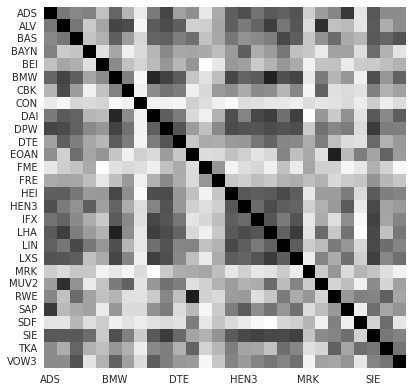

In [7]:
plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(3, 1)
ax_mat = plt.subplot(gs[1:, -2:])
plt.imshow(df.values, interpolation='nearest', axes=ax_mat)
ax_mat.set_yticks(np.arange(len(df.index)))
ax_mat.set_yticklabels(dax_info.loc[df.index]['Ticker symbol'].tolist())
ax_mat.set_xticklabels(dax_info.loc[df.index[map(int, ax_mat.get_xticks())[:-1]]]['Ticker symbol'].tolist())
ax_mat.grid(False)
plt.savefig('correlation.pdf', bbox='tight')

### A hierarchical structure (e.g. dendrogram) helps visualize the matrix

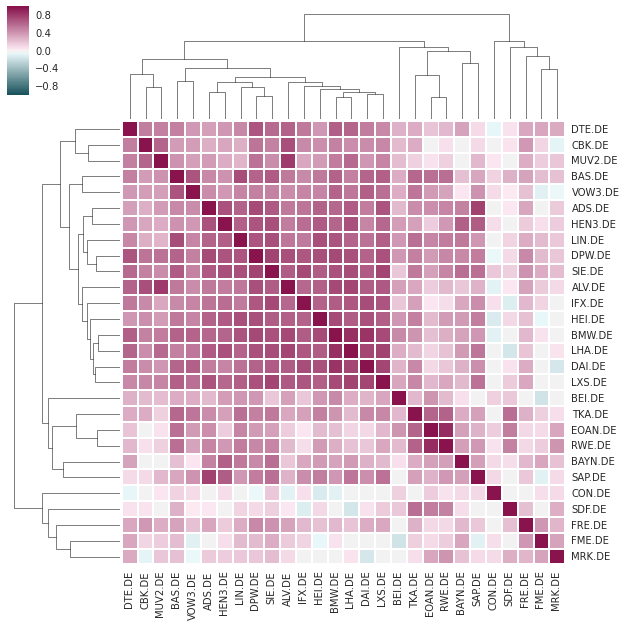

In [8]:
cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)
clustermap = sns.clustermap(df, cmap=cmap, 
                            vmin=-1, vmax=1)

We can also use bokeh

In [12]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource

In [13]:
output_notebook()

In [14]:
def to_data_source(df):
    Y = sch.linkage(df.values, method='centroid')
    Z = sch.dendrogram(Y, orientation='right', no_plot=True)
    index = Z['leaves']
    
    _names = df.columns.tolist()

    names = [_names[i] for i in index] # if i in range(5)]
    
    color_of = colorer()
#     xnames, ynames = zip( *((c,v) for c,v in permutations(names, r=2)))
    xnames = []
    ynames = []
    values = []
    colors = []
    for n in names:
        xnames.extend([n] * len(names))
        ynames.extend(names)
        v = df.loc[n, names].tolist()
        values.extend(v)
        colors.extend(map(color_of, v))
    source = ColumnDataSource(
        data=dict(
            xname = xnames,
            yname = ynames,
            colors= colors,
            values= values,
        )
    )
    return source, names

def colorer(number_colors = 21):
    basis = sns.blend_palette(["seagreen", "ghostwhite", "#4168B7"], number_colors)
    palette = ["rgb(%d, %d, %d)" % (r,g,b) for r,g,b, a in np.round(basis * 255)]
    def color_of(value):
        i = np.round((value + 1.) * (number_colors -1) * 0.5)
        return palette[int(i)]
    return color_of



In [15]:
def corrplot(source, names):
    p = figure(width=500, height=500, title="Correlation matrix",
               x_axis_location="above", tools="resize,hover,save",
               x_range=list(reversed(names)), y_range=names)
    
    p.rect('xname', 'yname', 0.9, 0.9, source=source,
           color='colors', line_color=None)
    
    p.grid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "5pt"
    p.axis.major_label_standoff = 0
    p.xaxis.major_label_orientation = np.pi/3
    hover = p.select(dict(type=HoverTool))
    hover.tooltips = OrderedDict([
        ('names', '@yname, @xname'),
        ('value', '@values')
    ])
    return p

In [27]:
df = ds.get_at( datetime.date(2003,1,6))

source, names = to_data_source(df)
bk  = corrplot(source, names)
show(bk)

## Construct Minimum Spanning Tree 

The goal is to reduce the redundancy in the correlation matrix and filter it, creating a graph.
One of the criteria for this is to compute the [Minimum Spanning Tree](http://en.wikipedia.org/wiki/Minimum_spanning_tree).

Minimum spanning trees are graphs of nodes so that
- all nodes are connected by at least one edge
- the sum of the edges is minimum
- contain no loops
- planar graph, i.e. there is a way of representing it in a 2D surface without any edges overlapping.

This kind of tree is particularly useful for representing complex networks, filtering the information about the correlations between all nodes and presenting it in a planar graph.
It is constructed using the Kruskal's algorithm. We use the implementation from the [NetworkX package](https://networkx.github.io/documentation/latest/reference/algorithms.mst.html).

The algorithm requires a transformation of the correlation matrix $[C_{ij}]$ into a distance matrix $[ d_{ij}]$

$$d_{ij}= \sqrt{2(1-C_{ij})}$$

Here is an example

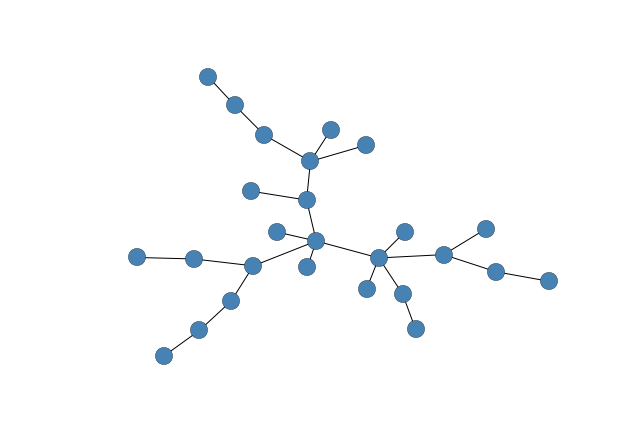

In [17]:
mst = network_utils.construct_mst(df)

def add_info(g, key, pds):
    new_attributes = map( lambda x: (x[0], x[1].decode('utf8')), filter(lambda i: g.has_node(i[0]), pds.iteritems()))
    nx.set_node_attributes(g, key, dict(new_attributes))

add_info(mst, 'group', dax_info['Prime Standard industry group'])
add_info(mst, 'label', dax_info.Company)

# fig =plt.figure()
# nx.draw_graphviz(mst, node_color='steelblue')
# import mpld3
# fig_d3 = mpld3.display(fig)
# display(fig_d3)
nx.draw_graphviz(mst, font_size=9, font_color='black', node_color='steelblue', labels=dict(map( lambda x: (x[0], x[1].decode('utf8')), filter(lambda i: mst.has_node(i[0]), dax_info.Company.iteritems()))))
plt.savefig('mst.pdf', bbox='tight')


### We are going to create a small dashboard to inspect the created networks

In [17]:
from graph import widgetforcelayout
from IPython.display import display
from IPython.html import widgets

In [18]:
def construct_dateslider(ds, callback=None):
    _time = pd.TimeSeries(ds.time_axis()) #.reindex()
    
    int_range = widgets.IntSliderWidget(min=100, max=_time.last_valid_index(), value=100, readout=False)        
    int_range.set_css({'width': '900'})
    
    text_area = widgets.LatexWidget()
    
    def get_current_date():
        i = int_range.value
        val = _time.ix[i]
        return val
    
    def date_to_string(datevalue):
        return "%s/%d/%d" % (datevalue.year, datevalue.month, datevalue.day)
        
    def f():
        new_date = get_current_date()
        new_val  = date_to_string(new_date)
        if new_val == text_area.value:
            return
        text_area.value = new_val
        if callback: callback(new_date)
    
    text_area.value = date_to_string(get_current_date())
    int_range.on_trait_change(f)
    
    date_container = widgets.ContainerWidget(children=[int_range, text_area])
#     date_container.set_css('border', '3px dotted grey')
    return date_container



In [70]:
widgetforcelayout.publish_js()
figure()
source, names = to_data_source(df)
bk  = corrplot(source, names)

graph_widget = widgetforcelayout.GraphWidget(height=500, width=600, link_distance=10, charge=-330,
                                             color_domain=dax_info['Prime Standard industry group'].unique().tolist())

bokeh_widget = widgets.HTMLWidget()
#bokeh_widget.value = notebook_div(curplot())

corr_container = widgets.ContainerWidget(children=[graph_widget, bokeh_widget])
# corr_container.set_css('border', '3px dotted grey')


import time
def update_matrix_mst(datevalue):
    _df = ds.get_at(datevalue)
    _source, _names = to_data_source(_df)
    bk  = corrplot(_source, _names)
    time.sleep(0.01)

    bokeh_widget.value = notebook_div(curplot())
    _mst = construct_mst(_df)
    add_info(_mst, 'group', dax_info['Prime Standard industry group'])
    add_info(_mst, 'label', dax_info.Company)

    time.sleep(0.01)
    graph_widget.set_graph(_mst)
    
date_container = construct_dateslider(ds, callback=update_matrix_mst)
date_container.msg_throttle = 1

mst_title = widgets.HTMLWidget()
mst_title.value='<h3>Minimum Spanning Tree</h3>'

container = widgets.ContainerWidget( children=[mst_title, corr_container, date_container] )



# display(mst_title)
display(container)

date_container.remove_class('vbox')
date_container.add_class('hbox')

corr_container.remove_class('vbox')
corr_container.add_class('hbox')

mst_stats.plot(figsize=(16,3))
plt.ylabel('Diameter MST')

<IPython.core.display.Javascript object>

AttributeError: 'IntSliderWidget' object has no attribute 'set_css'

### Diameter of Minimum Spanning Tree over time

In [20]:
%%time

# initialize DataFrame
all_t = ds.time_axis()
mst_stats = pd.DataFrame(columns=['diameter'], index=all_t)

# iterate
for t, df in ds.iterate_time():
    try:
        g = construct_mst(df)
        mst_stats.loc[t] = nx.algorithms.diameter(g)# #, nx.algorithms.degree_centrality}
    except ValueError as e:
        print "skipping ", t

CPU times: user 4min 44s, sys: 5.39 s, total: 4min 50s
Wall time: 4min 45s


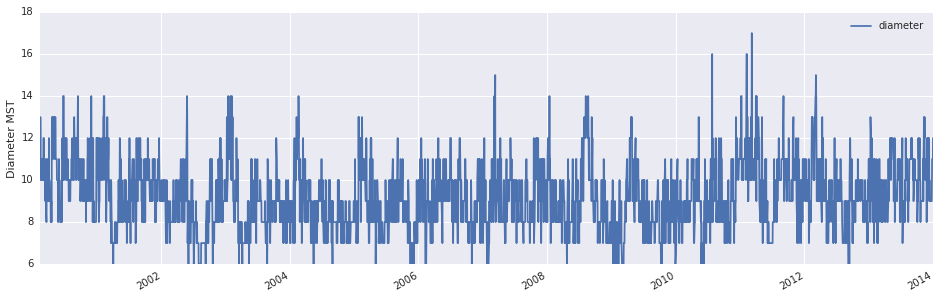

In [21]:
mst_stats.plot(figsize=(16,5))
plt.ylabel('Diameter MST')
plt.savefig('diameter.pdf', bbox='tight')

### Construct Planary Maximum Filtered Graph

We use the [planarity library](https://github.com/mvaz/planarity) in order to decide whether a graph is [planar](http://en.wikipedia.org/wiki/Planar_graph).

The benefits of the PMFG are discussed in length in 

   Song W-M, Di Matteo T, Aste T (2012) Hierarchical Information Clustering by Means of Topologically Embedded Graphs. PLoS ONE 7(3): e31929. [doi:10.1371/journal.pone.0031929](http://www.plosone.org/article/info%3Adoi%2F10.1371%2Fjournal.pone.0031929)
   
It basically offers a good trade-off between edge reduction and information retainment.

In [18]:
from graph.algos import construct_pmfg

In [19]:
def add_info_pmfg(g, key, prop_name, pds):
    idx = pds.columns.tolist().index(prop_name)
    new_attr = map( lambda r: (r[0], r[1][1][idx]), filter( lambda r: g.has_node(r[0]), enumerate(pds.iterrows())))
    nx.set_node_attributes(pmfg, key, dict(new_attr))


pmfg = construct_pmfg(df)
graph_widget = widgetforcelayout.GraphWidget(height=600, width=800, link_distance=25, charge=-1000)

    
# ['Ticker symbol']
add_info_pmfg(pmfg, 'label', 'Company', dax_info)
add_info_pmfg(pmfg, 'group', 'Prime Standard industry group', dax_info)
# pmfg.nodes(data=True)

display(graph_widget)
time.sleep(0.1)
graph_widget.set_graph(pmfg)

NameError: name 'widgetforcelayout' is not defined

In [20]:
map( lambda v: (dax_info.index[v[0]], v[1]), sorted( nx.algorithms.eigenvector_centrality(pmfg).items(), key=lambda x: x[1]))

[('LHA.DE', 0.0462714616404624),
 ('SDF.DE', 0.05888485289761572),
 ('SAP.DE', 0.06367947413695603),
 ('MUV2.DE', 0.0880910646679665),
 ('MRK.DE', 0.11545554762740445),
 ('BAYN.DE', 0.12015790362027058),
 ('BEI.DE', 0.1302397866515179),
 ('IFX.DE', 0.1378832574734035),
 ('FME.DE', 0.14535003194053794),
 ('BAS.DE', 0.14824064050528435),
 ('DPW.DE', 0.14916017315502966),
 ('FRE.DE', 0.15232009871385652),
 ('RWE.DE', 0.1537925837116456),
 ('DTE.DE', 0.1680937052467975),
 ('ADS.DE', 0.17070549784508474),
 ('LXS.DE', 0.1762519604276435),
 ('HEN3.DE', 0.179774355522497),
 ('EOAN.DE', 0.18296155165611053),
 ('LIN.DE', 0.1916490655195609),
 ('SIE.DE', 0.2058578082901865),
 ('CBK.DE', 0.22927341892749992),
 ('CON.DE', 0.23057314471661394),
 ('DAI.DE', 0.25010949057808823),
 ('HEI.DE', 0.30363876358513864),
 ('ALV.DE', 0.357277373119345),
 ('BMW.DE', 0.43027926957965534)]

In [25]:
mean_measure = lambda g, f_m, **d: np.mean(f_m(g, **d).values())

aggregated_centrality = lambda g: ( mean_measure( g, nx.algorithms.betweenness_centrality, weight='weight'), 
                                    mean_measure( g, nx.algorithms.closeness_centrality, distance='weight'), 
                                    mean_measure( g, nx.algorithms.eigenvector_centrality) )

aggregated_centrality(pmfg)

(0.046794871794871802, 0.53804593321556005, 0.17638354929831435)

### Compute PMFG aggregated statistics over time

In [22]:
%%time

# initialize DataFrame
all_t = ds.time_axis()
pmfg_stats = pd.DataFrame(columns=['betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality'], index=all_t)

# iterate
for t, df in ds.iterate_time():
    try:
        g = construct_pmfg(df)
        pmfg_stats.loc[t] = aggregated_centrality(g)# #, nx.algorithms.degree_centrality}
    except ValueError as e:
        print "skipping ", t

CPU times: user 3min 42s, sys: 2.8 s, total: 3min 45s
Wall time: 3min 41s


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fc2a7e590>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f1fc128d650>], dtype=object)

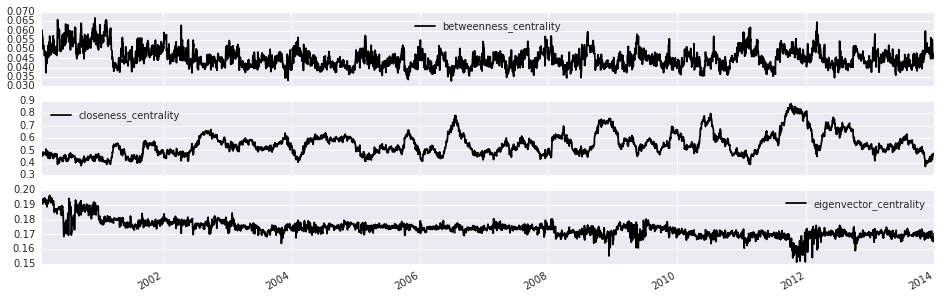

In [23]:
pmfg_stats
pmfg_stats.plot(figsize=(16,5), subplots=True)